In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

from glob import glob
from tqdm import tqdm

import imgaug as ia
from imgaug import augmenters as iaa

import argparse

parser = argparse.ArgumentParser(description='Reptile_2stage')
parser.add_argument('--resize_size', default=256, type=int)
parser.add_argument('--seed', default=1011, type=int)
args = parser.parse_args('')

resize_size=args.resize_size
SEED=args.seed

idx=11

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    ia.seed(seed)

set_seeds()

In [2]:
learning_rate = 0.003
meta_step_size = 0.25

inner_batch_size = 8
eval_batch_size = 8

meta_iters = 10
eval_iters = 5
inner_iters = 4

eval_interval = 1
train_shots = 10
shots = 5

In [3]:
%%time

import pickle
import gzip

with gzip.open(f'preprocess_data/train_imgs_256i.pkl','rb') as f:
    train_imgs = pickle.load(f)

with gzip.open(f'preprocess_data/test_imgs_256i.pkl','rb') as f:
    test_imgs = pickle.load(f)
    
train_imgs.shape, test_imgs.shape

CPU times: total: 22.6 s
Wall time: 22.6 s


((4277, 256, 256, 3), (2154, 256, 256, 3))

In [4]:
train_y = pd.read_csv("raw_data/train_df.csv")

class_list = np.sort(train_y["class"].unique())
train_y = train_y[train_y["class"]==class_list[idx]]

train_labels = train_y["label"]
label_unique = sorted(np.unique(train_labels))
label_unique = {key : value for key, value in zip(label_unique, range(len(label_unique)))}

good = train_y[train_y["state"]=="good"]
bad = train_y[train_y["state"]!="good"]
X_train = train_imgs[bad.index]
X_val = train_imgs[good.index]
y_train = bad["label"]
y_val = good["label"]

y_train = [label_unique[k] for k in y_train]
y_train = np.array(y_train)

y_val = [label_unique[k] for k in y_val]
y_val = np.array(y_val)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((15, 256, 256, 3), (60, 256, 256, 3), (15,), (60,))

In [5]:
np.sort(np.unique(y_train)), np.sort(np.unique(y_val))

(array([0]), array([1]))

In [6]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

train_ds = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .map(lambda x, y: (normalization_layer(x), y))
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = (
    tf.data.Dataset.from_tensor_slices((X_val, y_val))
    .map(lambda x, y: (normalization_layer(x), y))
    .prefetch(tf.data.AUTOTUNE)
)

test_ds = (
    tf.data.Dataset.from_tensor_slices((test_imgs))
    .map(lambda x: normalization_layer(x))
    .prefetch(tf.data.AUTOTUNE)
)

train_ds

<PrefetchDataset shapes: ((256, 256, 3), ()), types: (tf.float32, tf.int32)>

In [7]:
classes = train_labels.nunique()

class Dataset:
    def __init__(self, training):
        
        if training==True:
            ds = train_ds
        else:
            ds = val_ds
            
        self.data = {}
        
        def extraction(image, label):
            return image, label

        for image, label in ds.map(extraction):
            image = image.numpy()
            label = str(label.numpy())
            if label not in self.data:
                self.data[label] = []
            self.data[label].append(image)
        self.labels = list(self.data.keys())

    def get_mini_dataset(
        self, batch_size, repetitions, shots, num_classes, split=False
    ):
        temp_labels = np.zeros(shape=(num_classes * shots))
        temp_images = np.zeros(shape=(num_classes * shots,
                                      resize_size, resize_size, 3))
        if split:
            test_labels = np.zeros(shape=(num_classes))
            test_images = np.zeros(shape=(num_classes,
                                          resize_size, resize_size, 3))

        label_subset = random.choices(self.labels, k=num_classes)
        for class_idx, class_obj in enumerate(label_subset):
            temp_labels[class_idx * shots : (class_idx + 1) * shots] = class_idx
            if split:
                test_labels[class_idx] = class_idx
                images_to_split = random.choices(
                    self.data[label_subset[class_idx]], k=shots + 1
                )
                test_images[class_idx] = images_to_split[-1]
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = images_to_split[:-1]
            else:
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = random.choices(self.data[label_subset[class_idx]], k=shots)

        dataset = tf.data.Dataset.from_tensor_slices(
            (temp_images.astype(np.float32), temp_labels.astype(np.int32))
        )
        dataset = dataset.shuffle(100).batch(batch_size).repeat(repetitions)
        if split:
            return dataset, test_images, test_labels
        return dataset

In [8]:
train_dataset = Dataset(training=True)
test_dataset = Dataset(training=False)

In [9]:
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    pooling='avg',
)

base_model.trainable = False

inputs = layers.Input(shape=(resize_size, resize_size, 3))
x = base_model(inputs)
outputs = layers.Dense(classes, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile()
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 4,052,133
Trainable params: 2,562
Non-trainable params: 4,049,571
_________________________________________________________________


In [10]:
training = []
testing = []
for meta_iter in range(meta_iters):
    frac_done = meta_iter / meta_iters
    cur_meta_step_size = (1 - frac_done) * meta_step_size
    old_vars = model.get_weights()
    mini_dataset = train_dataset.get_mini_dataset(
        inner_batch_size, inner_iters, train_shots, classes
    )
    for images, labels in mini_dataset:
        with tf.GradientTape() as tape:
            preds = model(images)
            loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
    new_vars = model.get_weights()
    for var in range(len(new_vars)):
        new_vars[var] = old_vars[var] + (
            (new_vars[var] - old_vars[var]) * cur_meta_step_size
        )
    model.set_weights(new_vars)
    if meta_iter % eval_interval == 0:
        accuracies = []
        for dataset in (train_dataset, test_dataset):
            train_set, test_images, test_labels = dataset.get_mini_dataset(
                eval_batch_size, eval_iters, shots, classes, split=True
            )
            old_vars = model.get_weights()
            for images, labels in train_set:
                with tf.GradientTape() as tape:
                    preds = model(images)
                    loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
                grads = tape.gradient(loss, model.trainable_weights)
                optimizer.apply_gradients(zip(grads, model.trainable_weights))
            test_preds = model.predict(test_images)
            test_preds = tf.argmax(test_preds).numpy()
            num_correct = (test_preds == test_labels).sum()
            model.set_weights(old_vars)
            accuracies.append(num_correct / classes)
        training.append(accuracies[0])
        testing.append(accuracies[1])
        print(
            "batch %d: train=%f test=%f" % (meta_iter, accuracies[0], accuracies[1])
        )

batch 0: train=1.000000 test=0.000000
batch 1: train=1.000000 test=1.000000
batch 2: train=0.500000 test=1.000000
batch 3: train=1.000000 test=1.000000
batch 4: train=1.000000 test=0.000000
batch 5: train=0.000000 test=0.000000
batch 6: train=1.000000 test=0.000000
batch 7: train=0.000000 test=1.000000
batch 8: train=0.000000 test=0.000000
batch 9: train=0.000000 test=0.000000


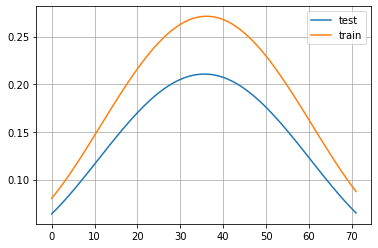

In [11]:
window_length = 100
train_s = np.r_[
    training[window_length - 1 : 0 : -1], training, training[-1:-window_length:-1]
]
test_s = np.r_[
    testing[window_length - 1 : 0 : -1], testing, testing[-1:-window_length:-1]
]
w = np.hamming(window_length)
train_y = np.convolve(w / w.sum(), train_s, mode="valid")
test_y = np.convolve(w / w.sum(), test_s, mode="valid")

x = np.arange(0, len(test_y), 1)
plt.plot(x, test_y, x, train_y)
plt.legend(["test", "train"])
plt.grid()

train_set, test_images, test_labels = dataset.get_mini_dataset(
    eval_batch_size, eval_iters, shots, classes, split=True
)
for images, labels in train_set:
    with tf.GradientTape() as tape:
        preds = model(images)
        loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
test_preds = model.predict(test_images)
test_preds = tf.argmax(test_preds).numpy()

## Inference

In [12]:
test_images.max(), model.predict(test_images).max()

(0.9254902601242065, 0.5031517)

In [13]:
pred_prob = model.predict(X_train/255)
f_pred = np.argmax(pred_prob, axis=1)
label_decoder = {val:key for key, val in label_unique.items()}
f_result = [label_decoder[result] for result in f_pred]

pd.Series(f_result).value_counts()

toothbrush-defective    15
dtype: int64

In [14]:
# pred_prob = model.predict(test_imgs/255)
# f_pred = np.argmax(pred_prob, axis=1)
# label_decoder = {val:key for key, val in label_unique.items()}
# f_result = [label_decoder[result] for result in f_pred]

# pd.Series(f_result).value_counts()

In [15]:
# submission = pd.read_csv("raw_data/sample_submission.csv")
# submission["label"] = f_result
# submission.to_csv("submission.csv", index=False)